Generating Long Sequences with Sparse Transformers

https://arxiv.org/abs/1904.10509

https://github.com/openai/sparse_attention/blob/master/attention.py


#### Factorized Self-Attention
ここで説明するのは、Decoderのself-attentionで行うmask処理についてです。
sparse transformerでは図のように、self-attentionをいくつかのattentionのステップに分けます。一番左の通常のtransformerでのattentionはfull self-attention、ほかの2つはsparse transformerで使用されるattentionでありfactorized self-attentionと呼ぶこととします。

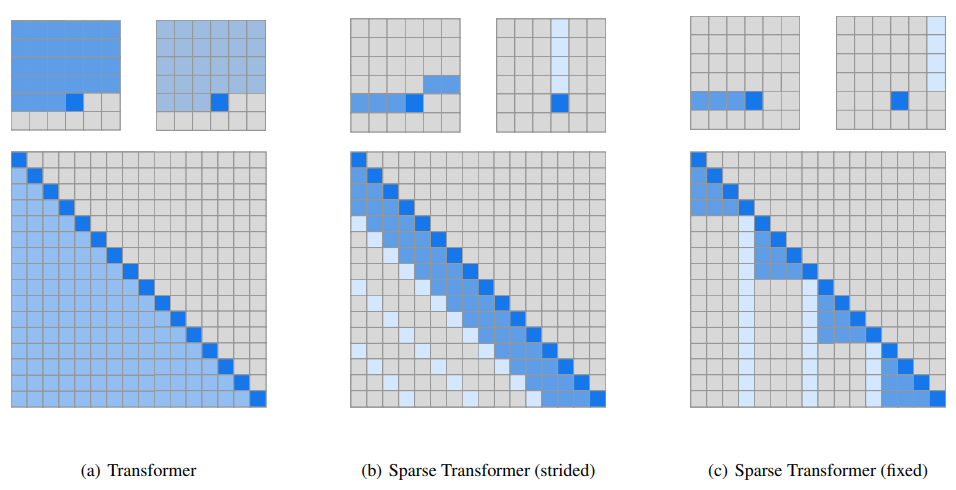


self-attention layerは、入力埋め込み$X$の行列を出力行列にマッピングし、接続パターン$S = {S_1, \cdots, S_n}$によってパラメータ化されます。ここで、$S_i$は$i$番目の出力ベクトルが注意を向ける入力ベクトルのインデックスのセットを表します。
出力ベクトルは、入力ベクトルの変換の加重和です。

$$
Attend(X,S)=\big(a(\boldsymbol{x}_i,S_i)\big)_{i\in\{1,\cdots,n\}}\\
a(\boldsymbol{x}_i,S_i)=softmax\bigg(\frac{(W_q\boldsymbol{x}_i)K_{S_i}^T}{\sqrt{d}} \bigg)V_{S_i}\\
K_{S_i}=(W_k\boldsymbol{x}_j)_{j\in S_i},\hspace{4mm}V_{S_i}=(W_v\boldsymbol{x}_j)_{j\in S_i}
$$

ここで、$W_q$、$W_k$、および$W_v$は、指定された$x_i$をquery、key、またはvalueに変換する重み行列を表し、$d$はクエリとキーの内部次元です。
各位置での出力は、keyとqueryのスケーリングされたドット積の類似性によって重み付けされたvalueの合計です。

full self-attentionでは、$Si = \{j : j \leq i\}$と定義して、すべての要素が自分より前のすべての位置と自分自身の位置に注意を向けることを可能にします。
factorized self-attentionには$p$個の個別のattention-headがあり、$m$番目のヘッドはインデックス$A_i^{(m)} \subset \{j : j \leq i\}$のサブセットを定義し、$Si = A_i^{(m)}$とします。ここで、$|A_i^{(m)}| \propto \sqrt[p]{n}$とします。

$A$の有効な選択を検討します。ここで、すべての入力位置は、attentionの$p$ステップ全体で将来のすべての出力位置に接続されます。
すべての$j \leq i$のペアについて、$i$が最大長$p + 1$のパスを介して$j$に注意できるように$A$を設定します。
具体的には、$(j, a, b, c, \cdots, i)$がインデックスのパスである場合、$j \in A_a^{(1)},a\in A_b^{(2)},b \in A_c^{(3)}$、などです。

2つのfactorized self-attentionによって計算量を$O(n\sqrt[p]{n})$に減らしながら、一定のステップ数で任意の入力位置から任意の出力位置に信号を伝搬するtransformerの能力を維持することができます。
次に$p = 2$の場合の2つの因数分解を調べますが、同じ手法をより高い次元に簡単に拡張できることに注意してください。

#### Two-dimensional factorized attention
2次元におけるfactorized attentionを定義する自然な方法としては、1つのheadを$l$前の位置まで注目させ、他方のheadを$l$ずつ前の位置を注目させていくことです。ここで、$l$はストライドで$\sqrt{n}$に近い値を選びます。これをstrided attentionと呼びます。

$$
A_i^{(1)}=\{t,t+1,\cdots,i\}\ for\ t=\max(0,i-l)\\
A_i^{(2)}=\{j:(i-j)\mod\ l=0\}
$$

この定式化は、画像やある種の音楽のように、ストライドに合わせた構造がデータにある場合に便利です。
ただし、テキストのように周期構造を持たないデータの場合、ネットワークがストライドを使用して情報を適切に取得できません。

そこで、fixed attentionを使用します。特定のセルが以前の場所を要約し、その情報を将来のすべてのセルに伝達します。

$$
A_i^{(1)}=\{j:([j/i]=[i/j])\}
$$

ここで$[・]$はフロア関数(整数部分を取得)を表します。

$$
A_i^{(2)}=\{j:j\mod l\in \{t,t+1,\cdots,l\} \}
$$

ここで、$t=l-c$であり、$c$はハイパーパラメータです。


#### Sparse Transformer
#####  Factorized attention heads
標準的なattentionでは、上で定義したattend関数の出力を線形変換します。

$$
attention(X)=W_p・attend(X,S)
$$

ここで、$W_p$は重み行列です。
因子分解されたself-attentionを統合するための最も簡単な方法としては、transformer blockごとに1つのattentionタイプを使用し、それらを順次またはハイパーパラメーターとして決定された比率で挟み込みます。

$$
attention(X)=W_p・attend(X,A^{(r\mod p)})
$$

ここで、$r$はtransformer blockのインデックスであり、$p$はfactorized attention headsの番号を表します。

2つ目のアプローチとして、factorized headsをまとめて1つのheadとするものです。これをmerged headと呼びます。

$$
attention(X)=W_p・attend(X,\cup_{m=1}^p A^{(m)} )
$$

3番目のアプローチは、multi-head-attentionを使うものです。
ここで、$n_h$個に分けて並列に計算し、結合するというものです。

$$
attention(X)=W_p\big(attend(X,A)^{i} \big)_{i\in (1,\cdots,n_h)}
$$

attend関数の中の重み行列の次元は$1/n_h$に縮小します。

#### Scaling to hundreds of layers


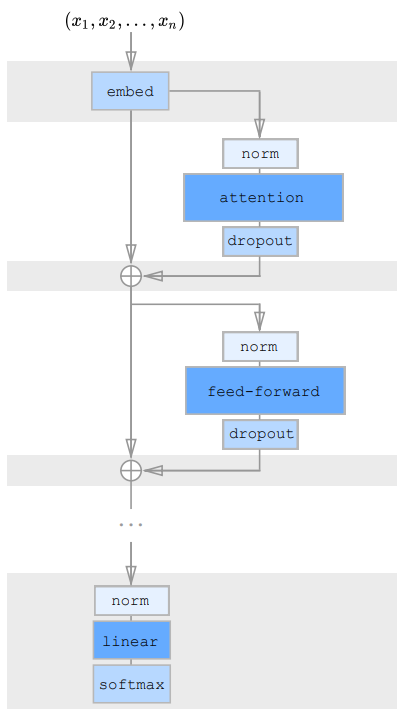

In [1]:
import sys
import numpy as np
import tensorflow as tf


def get_attn_mask(n, attn_mode, local_attn_ctx=None):
    if attn_mode == 'all':
        b = tf.linalg.band_part(tf.ones([n, n]), -1, 0)
    elif attn_mode == 'local':
        bandwidth = local_attn_ctx
        ctx = tf.minimum(n - 1, bandwidth - 1)
        b = tf.linalg.band_part(tf.ones([n, n]), ctx, 0)
    elif attn_mode == 'strided':
        stride = local_attn_ctx
        x = tf.reshape(tf.range(n, dtype=tf.int32), [n, 1])
        y = tf.transpose(x)
        z = tf.zeros([n, n], dtype=tf.int32)
        q = z + x
        k = z + y
        c1 = q >= k
        c2 = tf.equal(tf.math.floormod(q - k, stride), 0)
        c3 = tf.logical_and(c1, c2)
        b = tf.cast(c3, tf.float32)
    else:
        raise ValueError('Not yet implemented')
    b = tf.reshape(b, [1, 1, n, n])
    return 1-b
tf.concat([get_attn_mask(10, 'local', 3) if m%2 else get_attn_mask(10, 'strided', 3) for m in range(4)], axis=0)

<tf.Tensor: shape=(4, 1, 10, 10), dtype=float32, numpy=
array([[[[0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 0., 1., 1., 1., 1., 1., 1., 1.],
         [0., 1., 1., 0., 1., 1., 1., 1., 1., 1.],
         [1., 0., 1., 1., 0., 1., 1., 1., 1., 1.],
         [1., 1., 0., 1., 1., 0., 1., 1., 1., 1.],
         [0., 1., 1., 0., 1., 1., 0., 1., 1., 1.],
         [1., 0., 1., 1., 0., 1., 1., 0., 1., 1.],
         [1., 1., 0., 1., 1., 0., 1., 1., 0., 1.],
         [0., 1., 1., 0., 1., 1., 0., 1., 1., 0.]]],


       [[[0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
         [1., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
         [1., 1., 0., 0., 0., 1., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 1., 0., 0., 0., 1., 1., 1.],
         [1., 1., 1., 1., 1., 0., 0., 0., 1., 1.],
         [1., 1., 1., 

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Input, Dense, Conv1D, Activation, Dropout, LayerNormalization, Reshape, Embedding, MultiHeadAttention
from tensorflow.keras import activations
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import math

import matplotlib.pyplot as plt

In [3]:
class AddPositionalEncoding(Layer):
    '''
    入力テンソルに対し、位置の情報を付与して返すレイヤー
    see: https://arxiv.org/pdf/1706.03762.pdf

    PE_{pos, 2i}   = sin(pos / 10000^{2i / d_model})
    PE_{pos, 2i+1} = cos(pos / 10000^{2i / d_model})
    '''
    def call(self, inputs):
        fl_type = inputs.dtype
        batch_size, max_length, depth = tf.unstack(tf.shape(inputs))

        depth_counter = tf.range(depth) // 2 * 2  # 0, 0, 2, 2, 4, ...
        depth_matrix = tf.tile(tf.expand_dims(depth_counter, 0), [max_length, 1])  # [max_length, depth]
        depth_matrix = tf.pow(10000.0, tf.cast(depth_matrix / depth, fl_type))  # [max_length, depth]

        # cos(x) == sin(x + π/2)
        phase = tf.cast(tf.range(depth) % 2, fl_type) * math.pi / 2  # 0, π/2, 0, π/2, ...
        phase_matrix = tf.tile(tf.expand_dims(phase, 0), [max_length, 1])  # [max_length, depth]

        pos_counter = tf.range(max_length)
        pos_matrix = tf.cast(tf.tile(tf.expand_dims(pos_counter, 1), [1, depth]), fl_type)  # [max_length, depth]

        positional_encoding = tf.sin(pos_matrix / depth_matrix + phase_matrix)
        # [batch_size, max_length, depth]
        positional_encoding = tf.tile(tf.expand_dims(positional_encoding, 0), [batch_size, 1, 1])

        return inputs + positional_encoding

In [4]:
class MultiHeadAttention(Layer):
    '''
    Multi-Head Attentionレイヤ
    
    hidden_dim : Embeddingされた単語ベクトルの長さ
    heads_num : マルチヘッドAttentionのヘッド数
       ※hidden_numはheads_numで割り切れえる値とすること
    drop_rate : 出力のDropout率

    model = MultiheadAttention(
        hidden_dim = 512,
        head_num = 8,
        drop_rate = 0.5
    )
    '''
    def __init__(self, hidden_dim, heads_num, drop_rate=0.5):
        super(MultiHeadAttention, self).__init__()
        # 入力の線形変換
        # 重み行列は[hidden_dim, hidden_dim]
        self.query = Conv1D(hidden_dim, kernel_size=1)
        self.key   = Conv1D(hidden_dim, kernel_size=1)
        self.value = Conv1D(hidden_dim, kernel_size=1)
        
        # 出力の線形変換
        self.projection = Conv1D(hidden_dim, kernel_size=1)
        
        # 出力のDropout
        self.drop = Dropout(drop_rate)
        
        self.nf = hidden_dim
        self.nh = heads_num
    
    def atten(self, query, key, value, attention_mask, training):
        """
        Attention
        
        query, key, value : 入力
        attention_mask : attention weight に適用される mask
        """
        # 各値を取得
        shape = query.shape.as_list()
        batch_size = -1 if shape[0] is None else shape[0]
        token_num = shape[2] # トークン列数
        hidden_dim = shape[1]*shape[3] # 入力チャンネル数
        
        # ここで q と k の内積を取ることで、query と key の単語間の関連度のようなものを計算します。
        # tf.matmulで最後の2成分について積を計算(それ以外は形がそろっている必要あり)
        # transpose_bで転置
        # [token_num, hidden_dim/head_num] @ [hidden_dim/head_num, token_num] = [token_num, token_num]
        scores = tf.matmul(query, key, transpose_b=True)
        
        # scoreをhidden_dimの平方根割る
        scores = tf.multiply(scores, tf.math.rsqrt(tf.cast(hidden_dim, tf.float32)))
        
        # Attention Maskがあればscoreに加算
        # attention_mask: [batch_size, token_num, token_num] 
        # マスク(参照しない部分)の場所に1、使用する部分は0とする
        # 1の部分を -無限大にする(softmax(-無限大)=0となる)
        # 1. PADを無視
        # 2. DecoderのSelf-Attentionで未来の情報を参照できないようにする

        if attention_mask is not None:
            scores = scores + attention_mask * -1e9
        # softmax を取ることで正規化します
        # input(query) の各単語に対して memory(key) の各単語のどこから情報を引いてくるかの重み
        atten_weight = tf.nn.softmax(scores)
        
        # 重みに従って value から情報を引いてきます
        # [token_num, token_num] @ [token_num, hidden_dim/head_num] = [token_num, hidden_dim/head_num]
        # input(query) の単語ごとに memory(value)の各単語 に attention_weight を掛け合わせて足し合わせた ベクトル(分散表現の重み付き和)を計算
        context = tf.matmul(atten_weight, value)
        
        # 各ヘッドの結合(reshape)
        # 入力と同じ形に変換する
        context = tf.transpose(context, [0, 2, 1, 3])
        context = tf.reshape(context, (batch_size, token_num, hidden_dim))
        
        # 線形変換
        context = self.projection(context, training=training)
        
        return self.drop(context, training=training), atten_weight

    def _split(self, x):
        """
        query, key, valueを分割する
        
        入力 shape: [batch_size, length, hidden_dim] の時
        出力 shape: [batch_size, head_num, length, hidden_dim//head_num]
        """
        # 各値を取得
        hidden_dim = self.nf
        heads_num = self.nh
        shape = x.shape.as_list()
        batch_size = -1 if shape[0] is None else shape[0]
        token_num = shape[1] # トークン列数
        
        # [batch_size, token_num, hidden_dim] -> [batch_size, token_num, head_num, hidden_dim/head_num]
        # splitだが実際は次元を拡張する処理
        x = tf.reshape(x, (batch_size, token_num, heads_num, int(hidden_dim/heads_num)))
        
        # [batch_size, token_num, head_num, hidden_dim/head_num] -> [batch_size, head_num, token_num, hidden_dim/head_num]
        x = tf.transpose(x, [0, 2, 1, 3])
        return x
    
    def call(self, x, training, memory=None, attention_mask=None, return_attention_scores=False):
        """
        モデルの実行
        
        input : 入力(query) [batch_size, token_num, hidden_dim]
        memory : 入力(key, value) [batch_size, token_num, hidden_dim]
        attention_mask : attention weight に適用される mask
            [batch_size, 1, q_length, k_length] 
            pad 等無視する部分が 1 となるようなもの(Decoderで使用)
        return_attention_scores : attention weightを出力するか
        """
        # memoryが入力されない場合、memory=input(Self Attention)とする
        if memory is None:
            memory = x

        # input -> query
        # memory -> key, value
        # [batch_size, token_num, hidden_dim] @ [hidden_dim, hidden_dim] -> [batch_size, token_num, hidden_dim] 
        query = self.query(x)
        key = self.key(memory)
        value = self.value(memory)
        
        # ヘッド数に分割する
        # 実際はreshapeで次数を1つ増やす
        # [batch_size, token_num, hidden_dim] -> [batch_size, head_num, token_num, hidden_dim/head_num]
        query = self._split(query)
        key = self._split(key)
        value = self._split(value)
        
        # attention
        # 入力と同じ形の出力
        # context: [batch_size, token_num, hidden_dim]
        # score_weightsはEncoderではNoneとする
        context, attn_weights = self.atten(query, key, value, attention_mask, training)
        if not return_attention_scores:
            return context
        else:
            return context, attn_weights

In [5]:
class FeedForwardNetwork(Layer):
    '''
    Position-wise Feedforward Neural Network
    transformer blockで使用される全結合層
    '''
    def __init__(self, hidden_dim, drop_rate):
        super().__init__()
        # 2層構造
        # 1層目：チャンネル数を増加させる
        self.filter_dense_layer = Dense(hidden_dim * 4, use_bias=True, activation='gelu')
        
        # 2層目：元のチャンネル数に戻す
        self.output_dense_layer = Dense(hidden_dim, use_bias=True)
        self.drop = Dropout(drop_rate)

    def call(self, x, training):
        '''
        入力と出力で形が変わらない
        [batch_size, token_num, hidden_dim]
        '''
        
        # [batch_size, token_num, hidden_dim] -> [batch_size, token_num, 4*hidden_dim]
        x = self.filter_dense_layer(x)
        x = self.drop(x, training=training)
        
        # [batch_size, token_num, 4*hidden_dim] -> [batch_size, token_num, hidden_dim]
        return self.output_dense_layer(x)

In [6]:
class ResidualNormalizationWrapper(Layer):
    '''
    残差接続
    output: input + SubLayer(input)
    '''
    def __init__(self, layer, drop_rate):
        super().__init__()
        self.layer = layer # SubLayer : ここではAttentionかFFN
        self.layer_normalization = LayerNormalization()
        self.drop = Dropout(drop_rate)

    def call(self, x, training, memory=None, attention_mask=None, return_attention_scores=None):
        """
        AttentionもFFNも入力と出力で形が変わらない
        [batch_size, token_num, hidden_dim]
        """
        
        params = {}
        if memory is not None:
            params['memory'] = memory
        if attention_mask is not None:
            params['attention_mask'] = attention_mask
        if return_attention_scores:
            params['return_attention_scores'] = return_attention_scores
        
        out = self.layer_normalization(x)
        if return_attention_scores:
            out, attn_weights = self.layer(out, training, **params)
            out = self.drop(out, training=training)
            return x + out, attn_weights
        else:
            out = self.layer(out, training, **params)
            out = self.drop(out, training=training)
            return x + out

In [7]:
class EncoderLayer(Layer):
    """
    encoder layer : before ->[self attention -> FF]-> next
    それぞれ残差接続とLayerNormalizationの処理が含まれる
    """
    def __init__(self, hidden_dim, heads_num, drop_rate=0.2):
        """
        hidden_numはheads_numで割り切れえる値とすること
        """
        super().__init__()
        self.atten = ResidualNormalizationWrapper(
            layer = MultiHeadAttention(hidden_dim = hidden_dim, heads_num = heads_num, drop_rate = drop_rate),
            drop_rate = drop_rate)
        
        self.ffn = ResidualNormalizationWrapper(
            layer = FeedForwardNetwork(hidden_dim = hidden_dim, drop_rate = drop_rate),
            drop_rate = drop_rate)
    
    def call(self, input, training, memory=None, attention_mask=None, return_attention_scores=False):
        """
        入力と出力で形式が変わらない
        [batch_size, token_num, hidden_dim]
        """
        
        if return_attention_scores:
            x, attn_weights = self.atten(input,training, memory, attention_mask, return_attention_scores)
            x = self.ffn(x)
            return x, attn_weights
        else:
            x = self.atten(input, training, memory, attention_mask, return_attention_scores)
            x = self.ffn(x)
            return x

In [8]:
class Encoder(Layer):
    '''
    TransformerのEncoder
    '''
    def __init__(
            self,
            hopping_num, # Multi-head Attentionの繰り返し数
            heads_num, # Multi-head Attentionのヘッド数
            hidden_dim, # Embeddingの次数
            drop_rate, # ドロップアウトの確率
    ):
        super().__init__()
        self.hopping_num = hopping_num
        
        # Position Embedding
        self.add_position_embedding = AddPositionalEncoding()
        self.input_dropout_layer = Dropout(drop_rate)

        # Multi-head Attentionの繰り返し(hopping)のリスト
        self.attention_block_list = [EncoderLayer(hidden_dim, heads_num) for _ in range(hopping_num)]
        self.output_normalization = LayerNormalization()

    def call(
            self,
            input,
            training,
            memory=None,
            attention_mask=None,
            return_attention_scores=False
    ):
        '''
        input: 入力 [batch_size, length]
        memory: 入力 [batch_size, length]
        attention_mask: attention weight に適用される mask
            [batch_size, 1, q_length, k_length] 
            pad 等無視する部分が 0 となるようなもの(Decoderで使用)
        return_attention_scores : attention weightを出力するか
        出力 [batch_size, length, hidden_dim]
        '''
        # Positional Embedding
        embedded_input = self.add_position_embedding(input)
        query = self.input_dropout_layer(embedded_input, training=training)
        
        
        if return_attention_scores:
            # MultiHead Attentionを繰り返し適用
            for i in range(self.hopping_num):
                query, atten_weights = self.attention_block_list[i](query, training, memory, attention_mask, return_attention_scores)

            # [batch_size, token_num, hidden_dim]
            return self.output_normalization(query), atten_weights
        else:
            # MultiHead Attentionを繰り返し適用
            for i in range(self.hopping_num):
                query = self.attention_block_list[i](query, training, memory, attention_mask, return_attention_scores)

            # [batch_size, token_num, hidden_dim]
            return self.output_normalization(query)

In [9]:
class DecoderLayer(Layer):
    """
    decoder layer : before ->[mask attention -> enc attention -> FF]-> next
    mask attentionは未来の情報を参照しないためのマスクを適用
    enc attentionはencoderの出力をkey, valueとする。
    それぞれ残差接続とLayerNormalizationの処理が含まれる
    """
    def __init__(self, hidden_dim, heads_num, drop_rate=0.2):
        """
        hidden_numはheads_numで割り切れえる値とすること
        """
        super().__init__()
        self.mask_atten = ResidualNormalizationWrapper(
            layer = MultiHeadAttention(hidden_dim = hidden_dim, heads_num = heads_num, drop_rate = drop_rate),
            drop_rate = drop_rate)
        
        self.enc_atten = ResidualNormalizationWrapper(
            layer = MultiHeadAttention(hidden_dim = hidden_dim, heads_num = heads_num, drop_rate = drop_rate),
            drop_rate = drop_rate)
        
        self.ffn = ResidualNormalizationWrapper(
            layer = FeedForwardNetwork(hidden_dim = hidden_dim, drop_rate = drop_rate),
            drop_rate = drop_rate)
    
    def call(self, input, training, memory=None, attention_mask=None, return_attention_scores=False):
        """
        入力と出力で形式が変わらない
        [batch_size, token_num, hidden_dim]
        """
        
        if return_attention_scores:
            x, dec_attn_weights = self.mask_atten(input, training, memory=input, attention_mask=attention_mask, return_attention_scores=return_attention_scores)
            x, encdec_attn_weights = self.enc_atten(x, training, memory=memory, attention_mask=None, return_attention_scores=return_attention_scores)
            x = self.ffn(x)
            return x, dec_attn_weights, encdec_attn_weights
        else:
            x = self.mask_atten(input, training, memory=input, attention_mask=attention_mask, return_attention_scores=False)
            x = self.enc_atten(x, training, memory=memory, attention_mask=None, return_attention_scores=False)
            x = self.ffn(x)
            return x

In [10]:
class Decoder(Layer):
    '''
    TransformerのDecoder
    '''
    def __init__(
            self,
            hopping_num, # Multi-head Attentionの繰り返し数
            heads_num, # Multi-head Attentionのヘッド数
            hidden_dim, # Embeddingの次数
            drop_rate, # ドロップアウトの確率
    ):
        super().__init__()
        self.hopping_num = hopping_num
        
        # Position Embedding
        self.add_position_embedding = AddPositionalEncoding()
        self.input_dropout_layer = Dropout(drop_rate)

        # Multi-head Attentionの繰り返し(hopping)のリスト
        self.attention_block_list = [DecoderLayer(hidden_dim, heads_num) for _ in range(hopping_num)]
        self.output_normalization = LayerNormalization()

    def call(
            self,
            input,
            training,
            memory=None,
            attention_mask=None,
            return_attention_scores=False
    ):
        '''
        input: 入力 [batch_size, length]
        memory: 入力 [batch_size, length]
        attention_mask: attention weight に適用される mask
            [batch_size, 1, q_length, k_length] 
            pad 等無視する部分が 1 となるようなもの(Decoderで使用)
        出力 [batch_size, length, hidden_dim]
        '''
        # Positional Embedding
        embedded_input = self.add_position_embedding(input)
        query = self.input_dropout_layer(embedded_input, training=training)
        
        # MultiHead Attentionを繰り返し適用
        #for i in range(self.hopping_num):
        #    query = self.attention_block_list[i](query, training, memory, attention_mask, return_attention_scores)

        # [batch_size, token_num, hidden_dim]
        #return self.output_normalization(query)
    
        if return_attention_scores:
            # MultiHead Attentionを繰り返し適用
            for i in range(self.hopping_num):
                query, dec_attn_weights, encdec_attn_weights = self.attention_block_list[i](query, training, memory, attention_mask, return_attention_scores)

            # [batch_size, token_num, hidden_dim]
            return self.output_normalization(query), dec_attn_weights, encdec_attn_weights
        else:
            # MultiHead Attentionを繰り返し適用
            for i in range(self.hopping_num):
                query = self.attention_block_list[i](query, training, memory, attention_mask, return_attention_scores)

            # [batch_size, token_num, hidden_dim]
            return self.output_normalization(query)

In [35]:
class TransformerTimeSeriesForecast(Model):
    """
    Transformerベースの時系列予測モデル
    
    """
    def __init__(
            self,
            hopping_num, # Multi-head Attentionの繰り返し数
            heads_num, # Multi-head Attentionのヘッド数
            hidden_dim, # Embeddingの次数
            drop_rate, # ドロップアウトの確率
            local_attn_ctx,
    ):
        super().__init__()
        self.head_dim = heads_num
        self.local_attn_ctx = local_attn_ctx
        
        self.encoder = Encoder(hopping_num, heads_num, hidden_dim, drop_rate)
        self.decoder = Decoder(hopping_num, heads_num, hidden_dim, drop_rate)
        
        self.fc = Dense(8)
        self.dropout = Dropout(drop_rate)
        self.final_layer = Dense(1)

    def call(self, inputs, training, return_attention_scores=False):
        enc_input, dec_input = inputs
        
        #self_attention_mask=self._create_look_ahead_mask(dec_input)
        self_attention_mask=tf.concat([self._create_factorized_mask(dec_input, 'local', self.local_attn_ctx) if m%2 else self._create_factorized_mask(dec_input, 'strided', self.local_attn_ctx) for m in range(self.head_dim)], axis=1)
        self.m = self_attention_mask
        
        # [batch_size, token_num] -> [batch_size, token_num, hidden_dim]
        if return_attention_scores:
            enc_output, enc_atten_weights = self.encoder(enc_input, memory=enc_input, attention_mask=None,return_attention_scores=return_attention_scores)
        else:
            enc_output = self.encoder(enc_input, memory=enc_input, attention_mask=None,return_attention_scores=return_attention_scores)
        
        #dec_output = self.decoder(dec_input, memory=enc_output, attention_mask=self_attention_mask)
        if return_attention_scores:
            dec_output, dec_attn_weights, encdec_attn_weights = self.decoder(dec_input, memory=enc_output, attention_mask=self_attention_mask,return_attention_scores=return_attention_scores)
        else:
            dec_output = self.decoder(dec_input, memory=enc_output, attention_mask=self_attention_mask,return_attention_scores=return_attention_scores)
       
        
        # [batch_size, hidden_dim] -> [batch_size, NUMLABELS]
        fc_output = self.fc(dec_output)
        fc_output = self.dropout(fc_output)
        final_output = self.final_layer(fc_output)

        if return_attention_scores:
            return final_output, enc_atten_weights, dec_attn_weights, encdec_attn_weights
        else:
            return final_output
    
    def _create_look_ahead_mask(self, x):
        batch_size, length, _ = x.shape
        autoregression_array = tf.logical_not(tf.linalg.band_part(tf.ones([length, length], dtype=tf.bool), -1, 0))  # 下三角が False
        autoregression_array = tf.reshape(autoregression_array, [1, 1, length, length])
        return tf.cast(autoregression_array, dtype=tf.float32)
    
    def _create_factorized_mask(self, x_dec, attn_mode, local_attn_ctx=None):
        batch_size, n, _ = x_dec.shape
        if attn_mode == 'all':
            b = tf.linalg.band_part(tf.ones([n, n]), -1, 0)
        elif attn_mode == 'local':
            bandwidth = local_attn_ctx
            ctx = tf.minimum(n - 1, bandwidth - 1)
            b = tf.linalg.band_part(tf.ones([n, n]), ctx, 0)
        elif attn_mode == 'strided':
            stride = local_attn_ctx
            x = tf.reshape(tf.range(n, dtype=tf.int32), [n, 1])
            y = tf.transpose(x)
            z = tf.zeros([n, n], dtype=tf.int32)
            q = z + x
            k = z + y
            c1 = q >= k
            c2 = tf.equal(tf.math.floormod(q - k, stride), 0)
            c3 = tf.logical_and(c1, c2)
            b = tf.cast(c3, tf.float32)
        else:
            raise ValueError('Not yet implemented')
        b = tf.reshape(b, [1, 1, n, n])

        return 1-b

(654, 10, 8)
(654, 4, 8)
(654, 4, 8)


(0.0, 550.0)

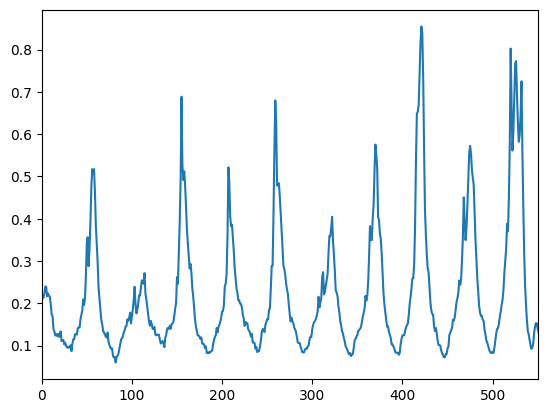

In [12]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

class minmaxscaling:
    def __init__(self,max_value, min_value, upl=0, downl=0):
        self.max = max_value + max_value*upl
        self.min = min_value - min_value*downl
    
    def translate(self, x):
        return (x - self.min) / (self.max - self.min)

window_width = 10
dmodel = 8
pred_points = 4

data = pd.read_csv('ilidata.csv')
train_data = np.array(data[['WEIGHTED_ILI']])

#scaler = StandardScaler()
#scaler.fit(train_data[:500])
#train_data = scaler.transform(train_data).ravel()

scaler = minmaxscaling(8, 0, 0.1)
train_data = scaler.translate(train_data).ravel()

emb_data = np.array([train_data[i:i+dmodel] for i in range(len(train_data)-dmodel)])

encinput = np.array([emb_data[i:i+window_width] for i in range(len(emb_data)-window_width-pred_points)])
print(encinput.shape)

decinput = np.array([emb_data[i+window_width-1:i+window_width-1+pred_points] for i in range(len(emb_data)-window_width-pred_points)])
print(decinput.shape)

y = np.array([emb_data[i+window_width:i+window_width+pred_points] for i in range(len(emb_data)-window_width-pred_points)])
print(y.shape)

enc_train, enc_test = encinput[:500,:,:], encinput[500:550,:,:]
dec_train, dec_test = decinput[:500,:,:], decinput[500:550,:,:]
y_train, y_test = y[:500,:,0], y[500:550,:,0]

enc_train = tf.constant(enc_train)
enc_test = tf.constant(enc_test)
dec_train = tf.constant(dec_train)
dec_test = tf.constant(dec_test)
y_train = tf.constant(y_train)
y_test = tf.constant(y_test)

plt.plot(y[:,-1,0]);
plt.xlim(0,550)

In [13]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import LearningRateScheduler

# 学習率を返す関数を用意する
def lr_schedul(epoch):
    lr = (dmodel**0.5) * min(epoch**0.5, epoch * (5000**(-1.5)))
    return lr


lr_decay = LearningRateScheduler(
    lr_schedul,
    # verbose=1で、更新メッセージ表示。0の場合は表示しない
    verbose=0,
)

model = TransformerTimeSeriesForecast(hopping_num=4, # Multi-head Attentionの繰り返し数
            heads_num=2, # Multi-head Attentionのヘッド数
            hidden_dim=dmodel, # Embeddingの次数
            drop_rate=0.2)

criterion = tf.keras.losses.MeanSquaredError()
optimizer = optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-09, amsgrad=False)

model.compile(loss=criterion, optimizer=optimizer, metrics=['mse'])

In [14]:
import time
start = time.time()
history=model.fit([enc_train,dec_train], y_train, batch_size=8, epochs=200, callbacks=[lr_decay],verbose=2)
elapsed_time = time.time() - start
print(elapsed_time)

Epoch 1/200
63/63 - 19s - loss: 2.8450 - mse: 2.8450 - lr: 0.0000e+00 - 19s/epoch - 302ms/step
Epoch 2/200
63/63 - 1s - loss: 2.7965 - mse: 2.7965 - lr: 8.0000e-06 - 685ms/epoch - 11ms/step
Epoch 3/200
63/63 - 1s - loss: 2.8775 - mse: 2.8775 - lr: 1.6000e-05 - 768ms/epoch - 12ms/step
Epoch 4/200
63/63 - 1s - loss: 2.5434 - mse: 2.5434 - lr: 2.4000e-05 - 733ms/epoch - 12ms/step
Epoch 5/200
63/63 - 1s - loss: 2.5908 - mse: 2.5908 - lr: 3.2000e-05 - 792ms/epoch - 13ms/step
Epoch 6/200
63/63 - 1s - loss: 2.1858 - mse: 2.1858 - lr: 4.0000e-05 - 695ms/epoch - 11ms/step
Epoch 7/200
63/63 - 1s - loss: 1.8988 - mse: 1.8988 - lr: 4.8000e-05 - 684ms/epoch - 11ms/step
Epoch 8/200
63/63 - 1s - loss: 1.7079 - mse: 1.7079 - lr: 5.6000e-05 - 700ms/epoch - 11ms/step
Epoch 9/200
63/63 - 1s - loss: 1.4993 - mse: 1.4993 - lr: 6.4000e-05 - 669ms/epoch - 11ms/step
Epoch 10/200
63/63 - 1s - loss: 1.2037 - mse: 1.2037 - lr: 7.2000e-05 - 745ms/epoch - 12ms/step
Epoch 11/200
63/63 - 1s - loss: 1.1235 - mse: 1.1

16/16 [==============================] - 3s 5ms/step


(0.0, 550.0)

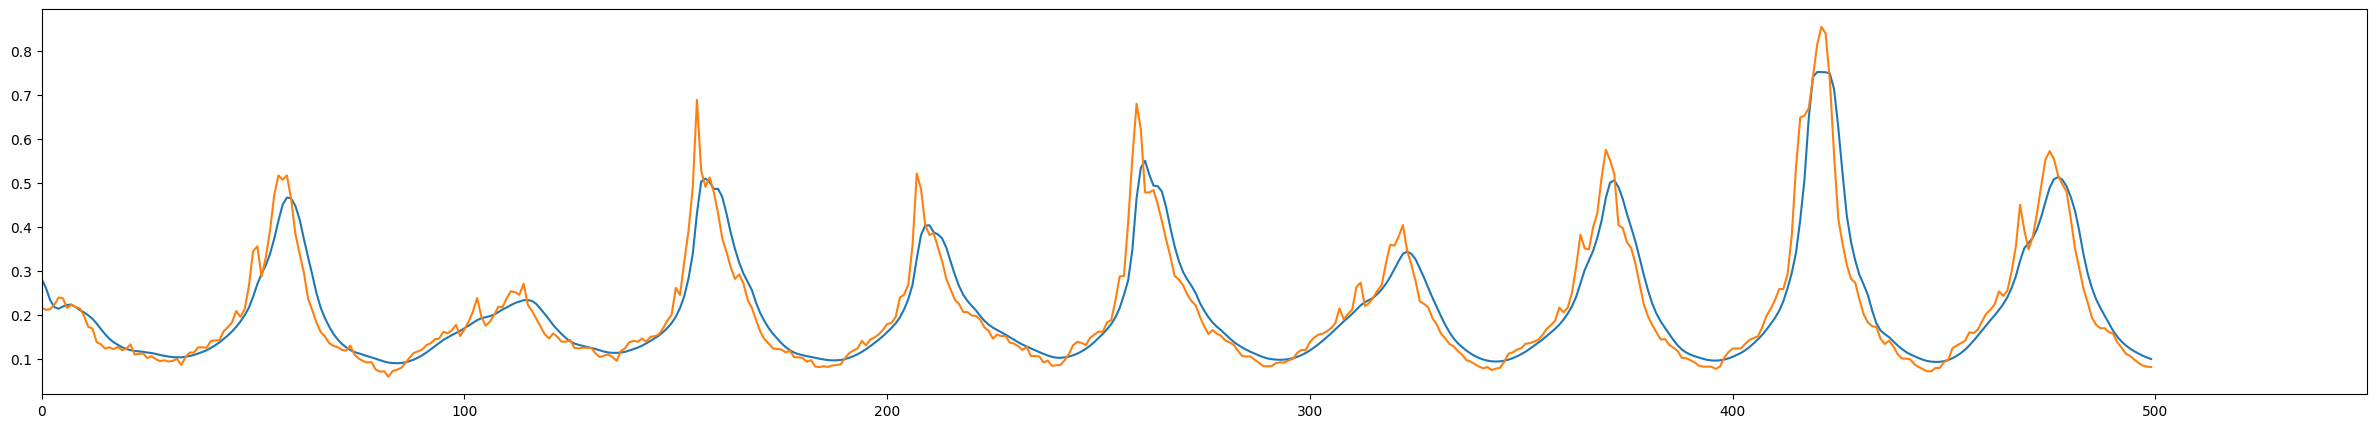

In [15]:
y_pred = model.predict([enc_train,dec_train])

plt.figure(figsize=(30,5))
plt.plot(y_pred[:,1,0])
plt.plot(y_train[:,-1]);
plt.xlim(0,550)

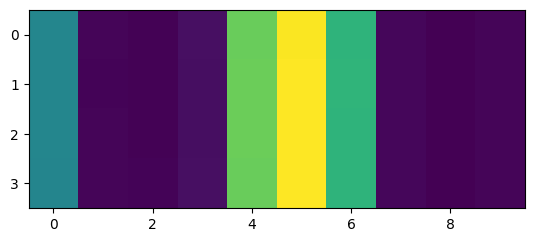

In [16]:
p, _, _, attn = model([enc_test,dec_test], return_attention_scores=True)
plt.imshow(attn[0,0])

In [17]:
pred_results = []

for j in range(len(enc_test)):
    for_pred = np.zeros((1,pred_points,dmodel))
    new_data = enc_test[j:j+1,-1:]

    for i in range(pred_points):
        for_pred[0,i,:] = new_data
        y_pred = model.predict([enc_test[j:j+1],for_pred], verbose=0)
        new_data = np.concatenate([enc_test[j:j+1,-1:,(i+1):], y_pred[0][:i+1].reshape(1,1,i+1)], axis=2)
    pred_results.append(y_pred)

pred_results = np.array(pred_results)

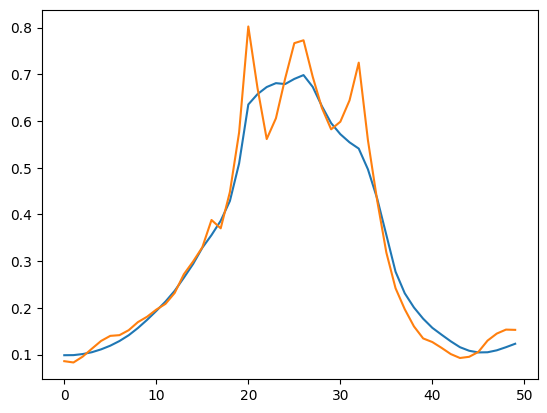

In [18]:
plt.plot(pred_results[:,0,-1,0])
plt.plot(y_test[:,-1]);

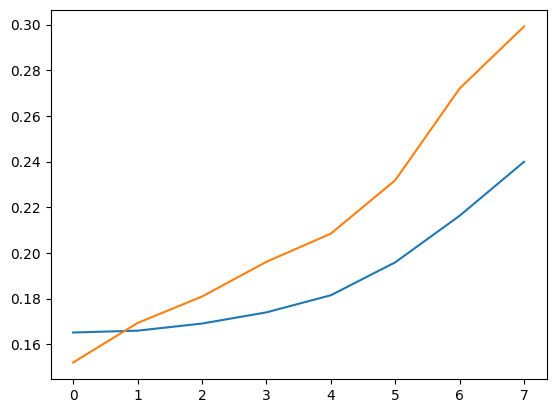

In [32]:
plt.plot(pred_results[10,0])
plt.plot(y_test[10,:])

(642, 10, 16)
(642, 8, 16)
(642, 8, 16)


(0.0, 550.0)

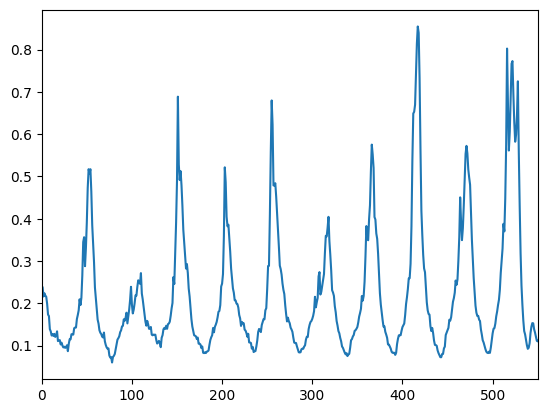

In [20]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

class minmaxscaling:
    def __init__(self,max_value, min_value, upl=0, downl=0):
        self.max = max_value + max_value*upl
        self.min = min_value - min_value*downl
    
    def translate(self, x):
        return (x - self.min) / (self.max - self.min)

window_width = 10
dmodel = 16
pred_points = 8

data = pd.read_csv('ilidata.csv')
train_data = np.array(data[['WEIGHTED_ILI']])

#scaler = StandardScaler()
#scaler.fit(train_data[:500])
#train_data = scaler.transform(train_data).ravel()

scaler = minmaxscaling(8, 0, 0.1)
train_data = scaler.translate(train_data).ravel()

emb_data = np.array([train_data[i:i+dmodel] for i in range(len(train_data)-dmodel)])

encinput = np.array([emb_data[i:i+window_width] for i in range(len(emb_data)-window_width-pred_points)])
print(encinput.shape)

decinput = np.array([emb_data[i+window_width-1:i+window_width-1+pred_points] for i in range(len(emb_data)-window_width-pred_points)])
print(decinput.shape)

y = np.array([emb_data[i+window_width:i+window_width+pred_points] for i in range(len(emb_data)-window_width-pred_points)])
print(y.shape)

enc_train, enc_test = encinput[:500,:,:], encinput[500:550,:,:]
dec_train, dec_test = decinput[:500,:,:], decinput[500:550,:,:]
y_train, y_test = y[:500,:,0], y[500:550,:,0]

enc_train = tf.constant(enc_train)
enc_test = tf.constant(enc_test)
dec_train = tf.constant(dec_train)
dec_test = tf.constant(dec_test)
y_train = tf.constant(y_train)
y_test = tf.constant(y_test)

plt.plot(y[:,-1,0]);
plt.xlim(0,550)

In [21]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import LearningRateScheduler

# 学習率を返す関数を用意する
def lr_schedul(epoch):
    lr = (dmodel**0.5) * min(epoch**0.5, epoch * (5000**(-1.5)))
    return lr


lr_decay = LearningRateScheduler(
    lr_schedul,
    # verbose=1で、更新メッセージ表示。0の場合は表示しない
    verbose=0,
)

model = TransformerTimeSeriesForecast(hopping_num=4, # Multi-head Attentionの繰り返し数
            heads_num=4, # Multi-head Attentionのヘッド数
            hidden_dim=dmodel, # Embeddingの次数
            drop_rate=0.2)

criterion = tf.keras.losses.MeanSquaredError()
optimizer = optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-09, amsgrad=False)

model.compile(loss=criterion, optimizer=optimizer, metrics=['mse'])

In [22]:
import time
start = time.time()
history=model.fit([enc_train,dec_train], y_train, batch_size=8, epochs=200, callbacks=[lr_decay],verbose=2)
elapsed_time = time.time() - start
print(elapsed_time)

Epoch 1/200
63/63 - 17s - loss: 1.8984 - mse: 1.8984 - lr: 0.0000e+00 - 17s/epoch - 263ms/step
Epoch 2/200
63/63 - 1s - loss: 1.9005 - mse: 1.9005 - lr: 1.1314e-05 - 883ms/epoch - 14ms/step
Epoch 3/200
63/63 - 1s - loss: 1.6387 - mse: 1.6387 - lr: 2.2627e-05 - 972ms/epoch - 15ms/step
Epoch 4/200
63/63 - 1s - loss: 1.5364 - mse: 1.5364 - lr: 3.3941e-05 - 1s/epoch - 16ms/step
Epoch 5/200
63/63 - 1s - loss: 1.3213 - mse: 1.3213 - lr: 4.5255e-05 - 1s/epoch - 18ms/step
Epoch 6/200
63/63 - 1s - loss: 1.0651 - mse: 1.0651 - lr: 5.6569e-05 - 996ms/epoch - 16ms/step
Epoch 7/200
63/63 - 1s - loss: 0.8936 - mse: 0.8936 - lr: 6.7882e-05 - 1s/epoch - 18ms/step
Epoch 8/200
63/63 - 1s - loss: 0.7742 - mse: 0.7742 - lr: 7.9196e-05 - 987ms/epoch - 16ms/step
Epoch 9/200
63/63 - 1s - loss: 0.6012 - mse: 0.6012 - lr: 9.0510e-05 - 1s/epoch - 20ms/step
Epoch 10/200
63/63 - 2s - loss: 0.4794 - mse: 0.4794 - lr: 1.0182e-04 - 2s/epoch - 25ms/step
Epoch 11/200
63/63 - 2s - loss: 0.4030 - mse: 0.4030 - lr: 1.131

In [23]:
y_pred = model.predict([enc_train,dec_train])

16/16 [==============================] - 4s 8ms/step


(0.0, 550.0)

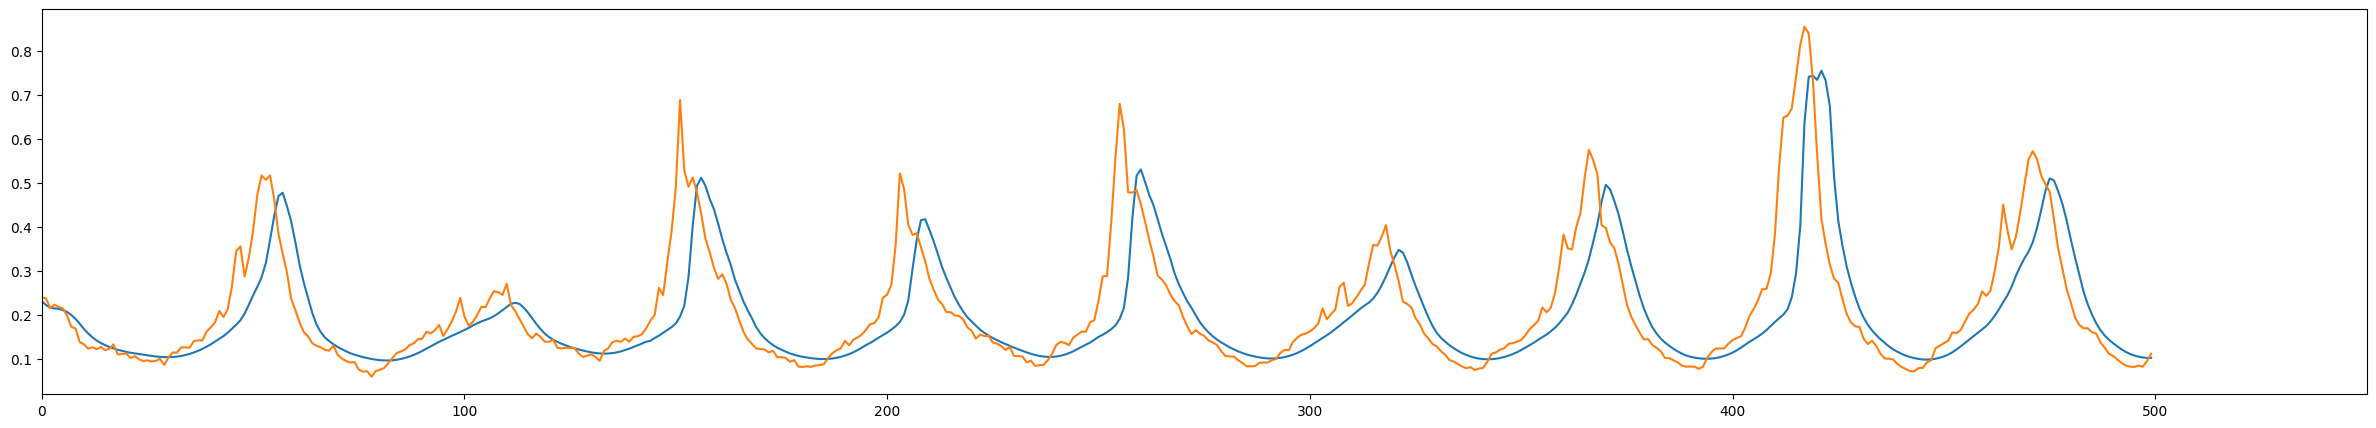

In [24]:
plt.figure(figsize=(30,5))
plt.plot(y_pred[:,3,0])
plt.plot(y_train[:,-1]);
plt.xlim(0,550)

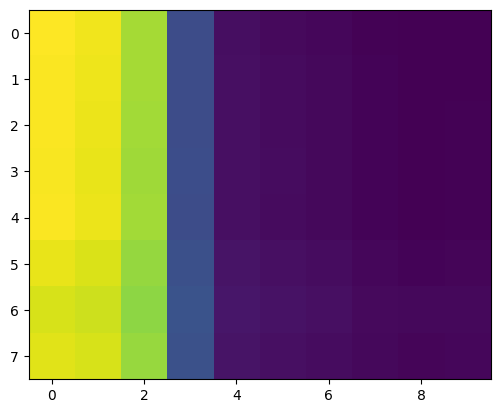

In [25]:
p, _, _, attn = model([enc_test,dec_test], return_attention_scores=True)
plt.imshow(attn[0,0])

In [26]:
pred_results = []

for j in range(len(enc_test)):
    for_pred = np.zeros((1,pred_points,dmodel))
    new_data = enc_test[j:j+1,-1:]

    for i in range(pred_points):
        for_pred[0,i,:] = new_data
        y_pred = model.predict([enc_test[j:j+1],for_pred], verbose=0)
        new_data = np.concatenate([enc_test[j:j+1,-1:,(i+1):], y_pred[0][:i+1].reshape(1,1,i+1)], axis=2)
    pred_results.append(y_pred)

pred_results = np.array(pred_results)

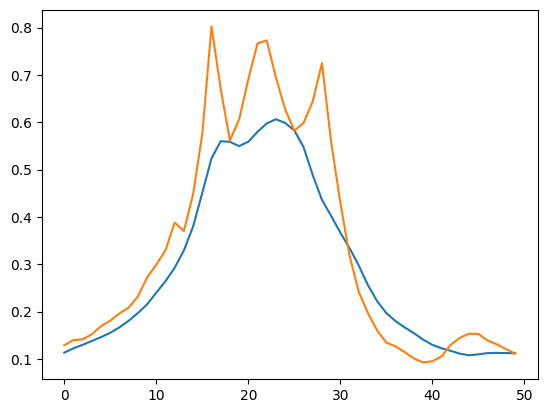

In [27]:
plt.plot(pred_results[:,0,-1,0])
plt.plot(y_test[:,-1]);
#plt.xlim(0,20)
#plt.ylim(0,4)

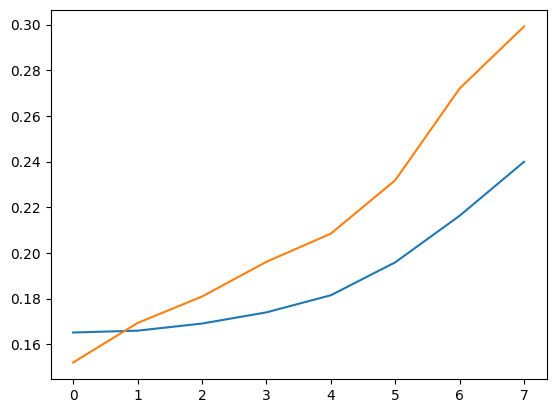

In [31]:
plt.plot(pred_results[10,0])
plt.plot(y_test[10,:])

In [29]:
model.save('sparse_transformer_predict')

INFO:tensorflow:Assets written to: sparse_transformer_predict\assets


INFO:tensorflow:Assets written to: sparse_transformer_predict\assets


(616, 20, 24)
(616, 16, 24)
(616, 16, 24)


(0.0, 550.0)

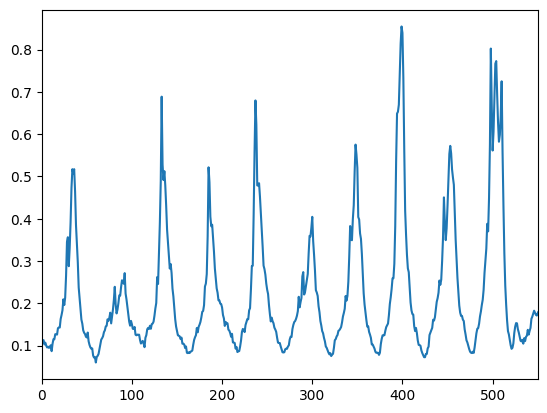

In [36]:
window_width = 20
dmodel = 24
pred_points = 16

data = pd.read_csv('ilidata.csv')
train_data = np.array(data[['WEIGHTED_ILI']])

#scaler = StandardScaler()
#scaler.fit(train_data[:500])
#train_data = scaler.transform(train_data).ravel()

scaler = minmaxscaling(8, 0, 0.1)
train_data = scaler.translate(train_data).ravel()

emb_data = np.array([train_data[i:i+dmodel] for i in range(len(train_data)-dmodel)])

encinput = np.array([emb_data[i:i+window_width] for i in range(len(emb_data)-window_width-pred_points)])
print(encinput.shape)

decinput = np.array([emb_data[i+window_width-1:i+window_width-1+pred_points] for i in range(len(emb_data)-window_width-pred_points)])
print(decinput.shape)

y = np.array([emb_data[i+window_width:i+window_width+pred_points] for i in range(len(emb_data)-window_width-pred_points)])
print(y.shape)

enc_train, enc_test = encinput[:500,:,:], encinput[500:550,:,:]
dec_train, dec_test = decinput[:500,:,:], decinput[500:550,:,:]
y_train, y_test = y[:500,:,0], y[500:550,:,0]

enc_train = tf.constant(enc_train)
enc_test = tf.constant(enc_test)
dec_train = tf.constant(dec_train)
dec_test = tf.constant(dec_test)
y_train = tf.constant(y_train)
y_test = tf.constant(y_test)

plt.plot(y[:,-1,0]);
plt.xlim(0,550)

In [37]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import LearningRateScheduler

# 学習率を返す関数を用意する
def lr_schedul(epoch):
    lr = (dmodel**0.5) * min(epoch**0.5, epoch * (5000**(-1.5)))
    return lr


lr_decay = LearningRateScheduler(
    lr_schedul,
    # verbose=1で、更新メッセージ表示。0の場合は表示しない
    verbose=0,
)

model = TransformerTimeSeriesForecast(hopping_num=4, # Multi-head Attentionの繰り返し数
            heads_num=4, # Multi-head Attentionのヘッド数
            hidden_dim=dmodel, # Embeddingの次数
            drop_rate=0.2,
            local_attn_ctx=3)

criterion = tf.keras.losses.MeanSquaredError()
optimizer = optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-09, amsgrad=False)

model.compile(loss=criterion, optimizer=optimizer, metrics=['mse'])

In [38]:
import time
start = time.time()
history=model.fit([enc_train,dec_train], y_train, batch_size=8, epochs=200, callbacks=[lr_decay],verbose=2)
elapsed_time = time.time() - start
print(elapsed_time)

Epoch 1/200
63/63 - 18s - loss: 2.1736 - mse: 2.1736 - lr: 0.0000e+00 - 18s/epoch - 286ms/step
Epoch 2/200
63/63 - 2s - loss: 1.9872 - mse: 1.9872 - lr: 1.3856e-05 - 2s/epoch - 28ms/step
Epoch 3/200
63/63 - 2s - loss: 1.6559 - mse: 1.6559 - lr: 2.7713e-05 - 2s/epoch - 29ms/step
Epoch 4/200
63/63 - 2s - loss: 1.2498 - mse: 1.2498 - lr: 4.1569e-05 - 2s/epoch - 29ms/step
Epoch 5/200
63/63 - 2s - loss: 0.8958 - mse: 0.8958 - lr: 5.5426e-05 - 2s/epoch - 28ms/step
Epoch 6/200
63/63 - 2s - loss: 0.6362 - mse: 0.6362 - lr: 6.9282e-05 - 2s/epoch - 29ms/step
Epoch 7/200
63/63 - 2s - loss: 0.4947 - mse: 0.4947 - lr: 8.3138e-05 - 2s/epoch - 28ms/step
Epoch 8/200
63/63 - 2s - loss: 0.3669 - mse: 0.3669 - lr: 9.6995e-05 - 2s/epoch - 27ms/step
Epoch 9/200
63/63 - 2s - loss: 0.2851 - mse: 0.2851 - lr: 1.1085e-04 - 2s/epoch - 29ms/step
Epoch 10/200
63/63 - 2s - loss: 0.2173 - mse: 0.2173 - lr: 1.2471e-04 - 2s/epoch - 28ms/step
Epoch 11/200
63/63 - 2s - loss: 0.1677 - mse: 0.1677 - lr: 1.3856e-04 - 2s/e

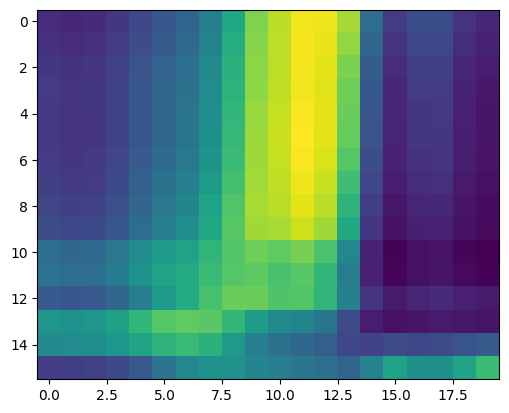

In [39]:
p, _, _, attn = model([enc_test,dec_test], return_attention_scores=True)
plt.imshow(attn[0,0])

In [40]:
pred_results = []

for j in range(len(enc_test)):
    for_pred = np.zeros((1,pred_points,dmodel))
    new_data = enc_test[j:j+1,-1:]

    for i in range(pred_points):
        for_pred[0,i,:] = new_data
        y_pred = model.predict([enc_test[j:j+1],for_pred], verbose=0)
        new_data = np.concatenate([enc_test[j:j+1,-1:,(i+1):], y_pred[0][:i+1].reshape(1,1,i+1)], axis=2)
    pred_results.append(y_pred)

pred_results = np.array(pred_results)

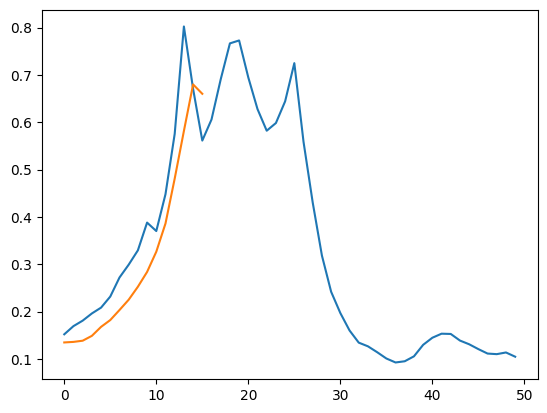

In [50]:
#plt.plot(pred_results[:,0,0,0])
plt.plot(y_test[:,0]);
plt.plot(pred_results[0,0])
#plt.xlim(0,20)
#plt.ylim(0,4)